**Load packages**

In [128]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# text-related stack
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# scikit-learn stack
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline 
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# imbalanced learn stack
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

**Load data**

In [129]:
#df = pd.read_csv('../data/music.csv', index_col=0)
df = pd.read_csv('../data/music_3.csv', index_col=0)

### 3.1 Check data

In [130]:
# dataframe head
df.head()

,group,song_lines
0,Kaleo,home grounds
1,Kaleo,feels like the weight has been lifted away
2,Kaleo,"but if she leaves me there, i won't run"
3,Kaleo,"please pass it on, carry me down"
4,Kaleo,"all you need to know is i want more, more"


In [131]:
# summary information on the data
df.info()
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13224 entries, 0 to 13223
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   group       13224 non-null  object
 1   song_lines  11992 non-null  object
dtypes: object(2)
memory usage: 309.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 11992 entries, 0 to 13223
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   group       11992 non-null  object
 1   song_lines  11992 non-null  object
dtypes: object(2)
memory usage: 281.1+ KB


In [132]:
# confirm no values missing
df.isna().sum().sum()

0

In [133]:
# check balance in target variable
df["group"].value_counts()

group
Coldplay    9580
Måneskin    1833
Kaleo        579
Name: count, dtype: int64

In [134]:
# check normalized balance in target variable
df["group"].value_counts(normalize=True)
#df.loc[df["group"] == "Kaleo", "group"] = 1
#df.loc[df["group"] == "Coldplay", "group"] = 0
#df.loc[df["group"] == "Måneskin", "group"] = 2
#df["group"].value_counts(normalize=True)


group
Coldplay    0.798866
Måneskin    0.152852
Kaleo       0.048282
Name: proportion, dtype: float64

In [135]:
df["group"].unique()

array(['Kaleo', 'Måneskin', 'Coldplay'], dtype=object)

***Observation: target variable is imbalanced (minority class = positive class = 1 class)***

### 3.2 *Stratified* Train-Test Split

In [136]:
# train-test split of features and labels
X_train, X_test, y_train, y_test = \
train_test_split(df["song_lines"], df["group"], test_size=0.05, random_state=42) #stratify=df["group"]

In [137]:
# train dataframe shape
X_train.shape, y_train.shape

((11392,), (11392,))

In [138]:
# target imbalance in training data
y_train.value_counts(normalize=True)

group
Coldplay    0.798894
Måneskin    0.153178
Kaleo       0.047928
Name: proportion, dtype: float64

In [139]:
y_train.unique()

array(['Coldplay', 'Måneskin', 'Kaleo'], dtype=object)

In [140]:
# test dataframe shape
X_test.shape, y_test.shape

((600,), (600,))

In [141]:
# target imbalance in test data
y_test.value_counts(normalize=True)

group
Coldplay    0.798333
Måneskin    0.146667
Kaleo       0.055000
Name: proportion, dtype: float64

### 3.3 A Simple Model

**Model building**

**Model evaluation**

### 3.4 Grid Search with Cross Validation

**Grid estimator**

In [143]:
estimator = imb_pipeline(
    steps=[
        # count vectorizer
        ('vectorizer', CountVectorizer(stop_words='english')),
        # tfidf transformer
        ('tfidf', None),
        # smote oversampling
        ('oversampler', None),
        # naive bayes classifier
        ('classifier', MultinomialNB())
    ]
)

**Parameter grid**

In [144]:
param_grid = {
    
    'tfidf': [
        None,
        TfidfTransformer(use_idf=False), 
        TfidfTransformer(use_idf=True)
    ],
    
    'oversampler': [
        None,
        RandomOverSampler(random_state=10,sampling_strategy=1.0),
        SMOTE(sampling_strategy=1.0)
    ],
    
    'classifier': [MultinomialNB(), ComplementNB(), RandomForestClassifier()]
}

**Grid-search cross-validation**

In [145]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

In [146]:
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(df['song_lines'],df['group'])

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
time taken: 16.58 sec


**Cross-validation results**

In [148]:
# list of columns to show
column_list = ['param_tfidf',
               'param_oversampler',
               'param_classifier',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
# create result dataframe
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

# rename columns
result_df.rename(
    columns=lambda name: name.split('param_')[-1],inplace=True
)

# order by rank
result_df.sort_values(
    by='rank_test_score', ascending=True, inplace=True, ignore_index=True
)

In [149]:
result_df.head(10)

,tfidf,oversampler,classifier,mean_test_score,std_test_score,rank_test_score
0,TfidfTransformer(),None,MultinomialNB(),0.868829,0.019710,1
1,TfidfTransformer(use_idf=False),None,MultinomialNB(),0.868662,0.019570,2
2,None,None,MultinomialNB(),0.866743,0.017649,3
3,TfidfTransformer(use_idf=False),None,RandomForestClassifier(),0.859824,0.007114,4
4,None,None,RandomForestClassifier(),0.857905,0.006541,5
5,TfidfTransformer(),None,RandomForestClassifier(),0.853486,0.008622,6
6,None,None,ComplementNB(),0.836559,0.015118,7
7,TfidfTransformer(),None,ComplementNB(),0.827386,0.013072,8
8,TfidfTransformer(use_idf=False),None,ComplementNB(),0.826218,0.011334,9
9,None,SMOTE(sampling_strategy=1.0),RandomForestClassifier(),NaN,NaN,10


**Best hyperparameters**

In [150]:
gscv.best_params_

{'classifier': MultinomialNB(),
 'oversampler': None,
 'tfidf': TfidfTransformer()}

**Best score**

In [151]:
round(gscv.best_score_,6)

0.868829

**Select best model**

In [152]:
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('oversampler', None),
                ('classifier', MultinomialNB())])

**Build model**

In [153]:
best_model.fit(X_train,y_train);

**Model performance**

In [154]:
# predictions on test data
y_pred = best_model.predict(X_test)


<Axes: >

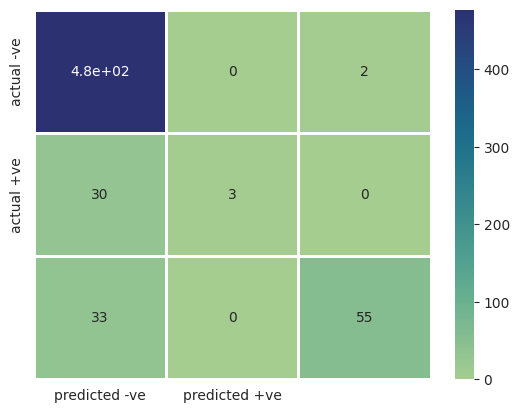

In [155]:
# confusion matrix heatmap
sns.heatmap(
    data=confusion_matrix(y_test,y_pred),
    cmap='crest',
    annot=True,
    linewidths=1,
    linecolor='white',
    xticklabels=['predicted -ve','predicted +ve'],
    yticklabels=['actual -ve','actual +ve']
)

<hr style="border:2px solid black">

In [156]:
y_pred = best_model.predict(['way down we go'])
y_pred 

array(['Coldplay'], dtype='<U8')

In [157]:
import pickle
model_filename = '../data/model_music_best_1.pkl'


pickle.dump(best_model, open(model_filename,'wb'))